In [1]:
import pandas as pd
from collections import Counter
from konlpy.tag import Okt, Kkma
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import Word2Vec
from gensim.models import doc2vec
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import ast
import numpy as np
import math
from time import time
from tqdm import tqdm
from collections import namedtuple
from gensim.models import Word2Vec, Doc2Vec
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib import rc
plt.style.use('seaborn')
# 그래프 출력에서 한글을 사용하기 위한 글꼴 설정
path = 'C:/Windows/Fonts/malgunsl.ttf'
prop = fm.FontProperties(fname=path, size=15)

def preprocessing(x, stop_words):
    okt = Okt()
    try:
        sentence_tokens = okt.nouns(x['summary'])
        genres = x['genre']
        #result = ''
        result = []
        for token in sentence_tokens: 
            if token not in stop_words:
                #result += ' ' + token 
                result.append(token)
        for genre in genres:
            result.append(genre)
            
        result.append(x['country'])
        return result
    except:
        return ['없음']
        
def rm_whitespace(x):
    result = []
    for i in x:
        if i != '':
            result.append(i)
        else:
            pass
    return result

In [2]:
# 데이터가 커서 길이를 설정해놓았습니다. nrows=10000 자체를 없애거나 숫자를 변경해서 데이터 크기를 조정해보세요.
df = pd.read_csv('test2.csv', nrows = 100000)
df_stopwords = pd.read_csv('data/한국어불용어100.txt',sep='\t', header=None,names=['words','b','c'])
lst_words = df_stopwords['words'].values

In [6]:
df1 = pd.read_csv('test.csv', nrows = 100000)
df1.head(1)

C:\Users\admin\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3173: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,userr,iitem1,iitem_copy,ttime,title,discription,iitem_level,actors,director,genre,runningtime,ttype,price,country,summary
0,500123965851,M01145M051PPV00,M01145M051PPV00,20210831235959,드래곤이 놀러 왔어요,뽀롱뽀롱 뽀로로2,5,"뽀로로, 패티, 포비, 루피",신창환,키즈|TV만화|,50000.0,일반,500.0,한국,"얼마 전 숲 속에서 길을 잃었던 패티와 친구가 된 드래곤! 드래곤은 어느 날, 문득..."


In [7]:
df.columns = ['userr','iitem1','logtime',
             'title','subtitle','main_genre','genre',
             'keyword','actors','country','price','summary']

In [9]:
df

,userr,iitem1,logtime,title,subtitle,main_genre,genre,keyword,actors,country,price,summary
53,500219371503,M0114A8347PPV00,20220101000710,마법의 스케치북,뽀롱뽀롱 뽀로로5,키즈,TV만화,NaN,"뽀로로, 로디, 에디, 크롱, 해리, 패티, 루피",NaN,500,그림을 그리면 그대로 이루어지는 `마법 스케치북` 하지만 크롱은 이 스케치북의 힘을...
55,500220180192,M0114A8347PPV00,20220103234644,마법의 스케치북,뽀롱뽀롱 뽀로로5,키즈,TV만화,NaN,"뽀로로, 로디, 에디, 크롱, 해리, 패티, 루피",NaN,500,그림을 그리면 그대로 이루어지는 `마법 스케치북` 하지만 크롱은 이 스케치북의 힘을...
58,500223920700,M0114A8347PPV00,20220103224754,마법의 스케치북,뽀롱뽀롱 뽀로로5,키즈,TV만화,NaN,"뽀로로, 로디, 에디, 크롱, 해리, 패티, 루피",NaN,500,그림을 그리면 그대로 이루어지는 `마법 스케치북` 하지만 크롱은 이 스케치북의 힘을...
59,500219371503,M0114A8347PPV00,20220103223816,마법의 스케치북,뽀롱뽀롱 뽀로로5,키즈,TV만화,NaN,"뽀로로, 로디, 에디, 크롱, 해리, 패티, 루피",NaN,500,그림을 그리면 그대로 이루어지는 `마법 스케치북` 하지만 크롱은 이 스케치북의 힘을...
60,500060926093,M0114A8347PPV00,20220103223643,마법의 스케치북,뽀롱뽀롱 뽀로로5,키즈,TV만화,NaN,"뽀로로, 로디, 에디, 크롱, 해리, 패티, 루피",NaN,500,그림을 그리면 그대로 이루어지는 `마법 스케치북` 하지만 크롱은 이 스케치북의 힘을...
...,...,...,...,...,...,...,...,...,...,...,...,...
99939,500118343981,M0115AS348PPV00,20220102083403,프랑키 Z,스푸키즈1,키즈,애니,"키즈, 애니, 영유아, 어린이, 키링, 슬랩스틱, 코미디, KTH, 만화","프랑키, 지지, 콩콩, 큐라, 캐비",NaN,300,"콩콩이는 박스로 마을을 만들어요. 뿌듯해하는 순간, 큐라와 캐비가 마을을 습격해요!..."
99942,500237091166,M01165J411PPV00,20220103150857,스푸키즈와 함께 크리스마스를!,스푸키즈2,키즈,애니,"KTH, 키즈, 애니, 유아, 어린이, 슬랩스틱, 코미디, 학교, 친구, 몬스터, ...","캐비, 지지, 콩콩, 프랑키, 큐라",NaN,500,신비로운 밤거리에 울려 퍼지는 스푸키즈들의 캐롤! 크리스마스는 스푸키즈와 함께해요!
99945,500118343981,M01165J411PPV00,20220102084230,스푸키즈와 함께 크리스마스를!,스푸키즈2,키즈,애니,"KTH, 키즈, 애니, 유아, 어린이, 슬랩스틱, 코미디, 학교, 친구, 몬스터, ...","캐비, 지지, 콩콩, 프랑키, 큐라",NaN,500,신비로운 밤거리에 울려 퍼지는 스푸키즈들의 캐롤! 크리스마스는 스푸키즈와 함께해요!
99948,500133496644,M01201A213PPV00,20220102191613,지독한 방귀 냄새의 비밀!,최고다! 호기심딱지4,키즈,놀이교실,"EBS, 키즈, 놀이교실, 수학과학, 교육, 호기심, 안전사고, 생활습관",없음,한국,500,방귀 냄새가 지독한 호떡이에게 호빵이가 방귀냄새가 왜 지독해지는지 '호기심딱지'를 ...


In [10]:
# 1회 이상 시청 고객
df_user_watch=pd.DataFrame(df['userr'].value_counts())
df_user_watch.columns=['cnt_watch']
lst_user_real = df_user_watch.loc[df_user_watch['cnt_watch']>=10].index
df = df.loc[df['userr'].isin(lst_user_real)]

# 변수 전처리
#df['genre'] = df['genre'].apply(lambda x: x.split("|"))
#df['genre'] = df['genre'].apply(lambda x: rm_whitespace(x))
df['genre'] = df['genre'].fillna('없음')
df['actors'] = df['actors'].fillna('없음')
#df['director'] = df['director'].fillna('없음')
df['actors'] = df['actors'].apply(lambda x: x.split(","))
df['country'] = df['country'].fillna('없음')
df['genre'] = df['genre'].fillna('없음')
df['summary'] = df['summary'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
df['comebine_col'] = df.apply(lambda x: preprocessing(x, lst_words), axis=1)

# 유저 아이디 인코딩
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['userr'] = le.fit_transform(df['userr']).astype(str)
le = LabelEncoder()
df['iitem1'] = le.fit_transform(df['iitem1']).astype(str)

In [22]:
df['genre'].unique()

array(['TV만화', '노래율동', '놀이교실', '시리즈', '어린이방송', '액션/모험', '코미디', '애니',
       '드라마', '유아애니', 'MCN', '외국어', '극장판 애니', '노래 율동', '예능', '창의학습'],
      dtype=object)

In [18]:
# genre, country, people
selected_features = ["genre", "country", "actors", "summary"]
all_genre_list = []
all_country_list = []
all_people_list = []
all_plot_list = []

for index, row in df.iterrows():
    genres = row["genre"]
    coutries = row["country"]
    people = row["actors"]
    plots = row["summary"]
    #genres = ast.literal_eval(genres)
    #coutries = ast.literal_eval(coutries)
    #people = ast.literal_eval(people)
    for genre in genres:
        if genre not in all_genre_list:
            all_genre_list.append(genre)
    for country in coutries:
        if country not in all_country_list:
            all_country_list.append(country)
    #print(people)
    for person in people:
        if person not in all_people_list:
            all_people_list.append(person)
    for plot in plots:
        if plot not in all_plot_list:
            all_plot_list.append(plot)
num_genres = len(all_genre_list)
num_countries = len(all_country_list)
num_people = len(all_people_list)
num_plot = len(all_plot_list)

# 영화 장르 시각화

In [23]:
# 전체 영화 장르 종류
df['genre'].unique()

array(['TV만화', '노래율동', '놀이교실', '시리즈', '어린이방송', '액션/모험', '코미디', '애니',
       '드라마', '유아애니', 'MCN', '외국어', '극장판 애니', '노래 율동', '예능', '창의학습'],
      dtype=object)

## 전체 영화의 장르 빈도

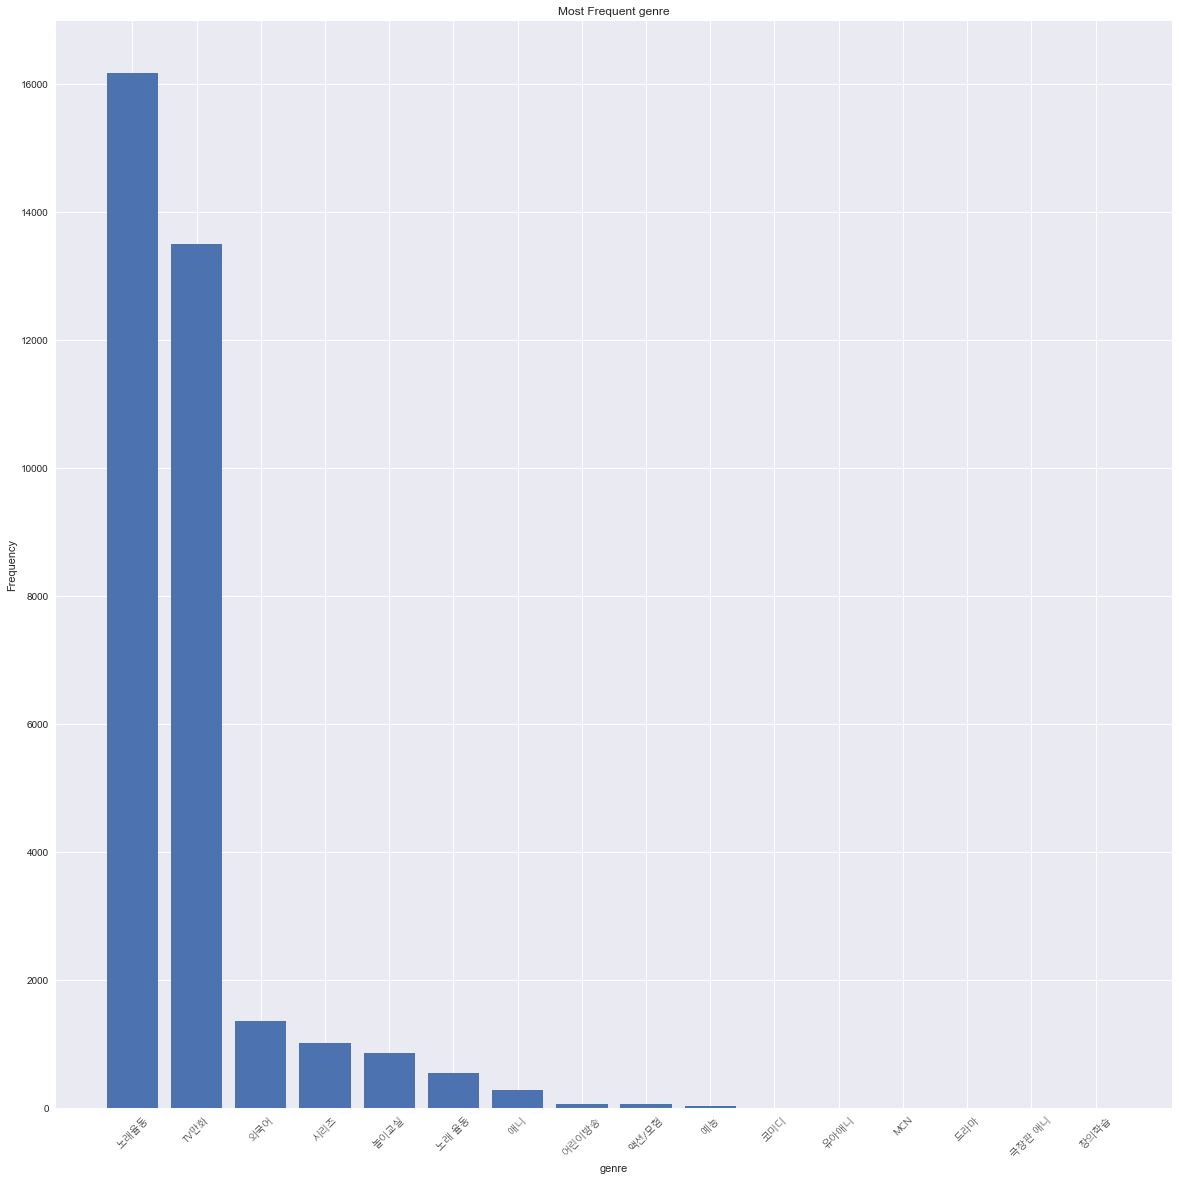

In [13]:
# 단어 취합
#total = sum(df['genre'].values.tolist(),[])
total = df['genre'].values
# 단어의 출현빈도수 추출
total_frequency_dict = dict(Counter(total))
# 추출한 단어별 출현빈도수를 테이블화
frequency_df = pd.DataFrame(zip(total_frequency_dict.keys(), total_frequency_dict.values()),columns=['name','frequency'])
# 빈도 수를 기준으로 내림차순
frequency_df = frequency_df.sort_values(by='frequency', ascending=False)

plt.figure(figsize=(20,20))
heights = frequency_df.frequency.values.tolist()
bars = frequency_df.name.values.tolist()
y_pos = range(len(bars))
plt.bar(y_pos, heights)
# Rotation of the bars names
plt.xticks(y_pos, bars, rotation=45,fontproperties=prop,fontsize=10)
plt.xlabel('genre') 
#y-axis labels 
plt.ylabel('Frequency') 
#plot title 
plt.title('Most Frequent genre') 
#display 
plt.show();

# 영화 개봉 국가 시각화

In [14]:
# 전체 영화 개봉 국가 종류
df['country'].unique()

array(['없음', '한국', 'South Korea', 'Jersey', '영국', '미국', '일본', 'US', '중국',
       'United Kingdom', '스위스', 'CN', 'KR'], dtype=object)

## 전체 개봉 국가 빈도

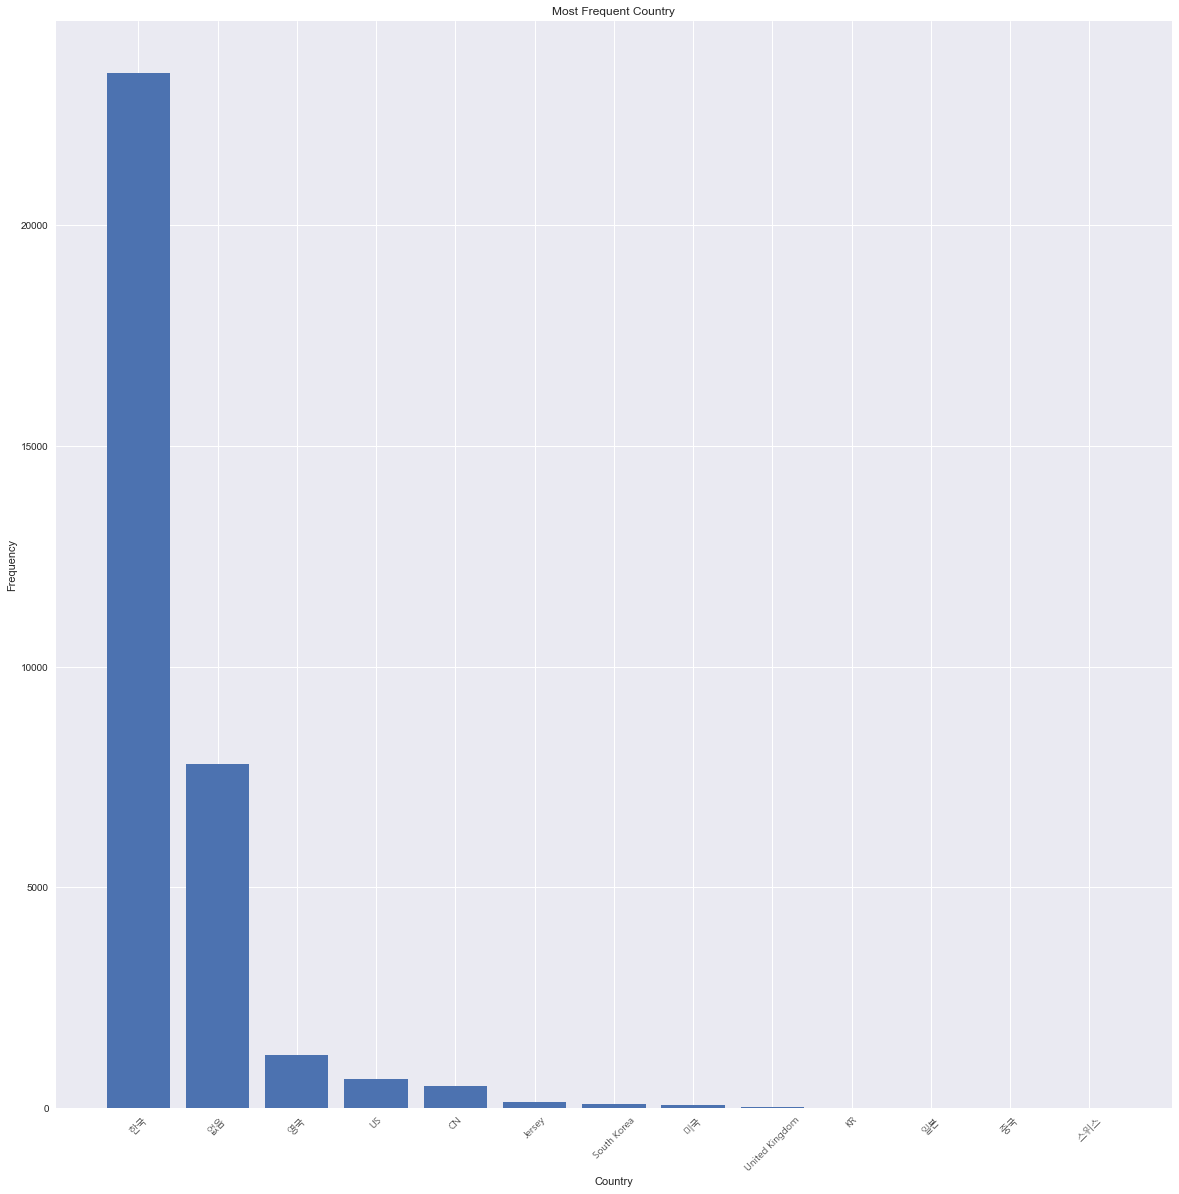

In [15]:
# 단어 취합
total = df['country'].values
# 단어의 출현빈도수 추출
total_frequency_dict = dict(Counter(total))
# 추출한 단어별 출현빈도수를 테이블화
frequency_df = pd.DataFrame(zip(total_frequency_dict.keys(), total_frequency_dict.values()),columns=['name','frequency'])
# 빈도 수를 기준으로 내림차순
frequency_df = frequency_df.sort_values(by='frequency', ascending=False)

plt.figure(figsize=(20,20))
heights = frequency_df.frequency.values.tolist()
bars = frequency_df.name.values.tolist()
y_pos = range(len(bars))
plt.bar(y_pos, heights)
# Rotation of the bars names
plt.xticks(y_pos, bars, rotation=45,fontproperties=prop,fontsize=10)
plt.xlabel('Country') 
#y-axis labels 
plt.ylabel('Frequency') 
#plot title 
plt.title('Most Frequent Country') 
#display 
plt.show();

# 영화 배우 시각화

In [25]:
# 전체 영화 배우 리스트
all_people_list

['뽀로로',
 ' 로디',
 ' 에디',
 ' 크롱',
 ' 해리',
 ' 패티',
 ' 루피',
 ' 포비',
 ' 패디',
 '타요',
 ' 로기',
 ' 라니',
 ' 가니',
 '띠띠뽀',
 ' 지니',
 ' 디젤',
 ' 에릭',
 ' 씽씽',
 ' 로코',
 '둘리',
 ' 열무',
 '추추',
 ' 뿅뿅이',
 ' 곰곰이',
 ' 시투',
 '옐로우',
 ' 레드',
 ' 브라운',
 '티피',
 ' 해머',
 ' 싸이언',
 ' 토토',
 '봉구',
 ' 바바',
 '토미',
 ' 새미',
 ' 빵빵',
 '뚜뚜',
 ' 하리',
 ' 야호',
 '닥터 몸',
 ' 호빵',
 ' 원간호사',
 '없음',
 '로미',
 ' 이안',
 ' 마야',
 '볼트',
 ' 루시',
 ' 맥스',
 '바나클',
 ' 콰지',
 ' 페이소',
 '렉스',
 ' 티록',
 ' 트록',
 ' 안키',
 '엄마 까투리',
 ' 꽁지',
 ' 마지',
 ' 두리',
 ' 세찌',
 '차탄',
 ' 잭슈트',
 '콩순이',
 ' 세요',
 ' 밤이',
 ' 송이',
 ' 전다혜',
 ' 차산',
 ' 바둑이',
 ' 카봇 에이스',
 ' 에밀리',
 ' 존',
 ' 티라노 다크노',
 '강태양',
 ' 스피드',
 ' 몬스터',
 ' 로켓',
 ' 비키',
 ' 토모',
 ' 핑',
 '스폰지밥',
 ' 뚱이',
 ' 징징이',
 ' 집게사장',
 ' 황장군',
 ' 차탄아빠',
 ' 다람이',
 '루비',
 ' 소피',
 ' 꼬마왕자',
 ' 스피넬',
 ' 티라노',
 '나찬',
 ' 이소벨',
 ' 공주희',
 ' 다나',
 ' 반다인',
 '해일',
 ' 강풍',
 ' 수리',
 ' 고운',
 ' 원만',
 '하나',
 ' 세모',
 ' 딩요',
 ' 수호',
 ' 오혜라',
 ' 에이스 레스큐 X',
 ' 아띠',
 ' 비비',
 ' 샤랄라',
 ' 도운',
 ' 디룩',
 '다래',
 ' 코리리',
 ' 티라쿵',
 '에그박사',
 '핑구',
 '레드',


## 전체 영화 배우 출연 빈도

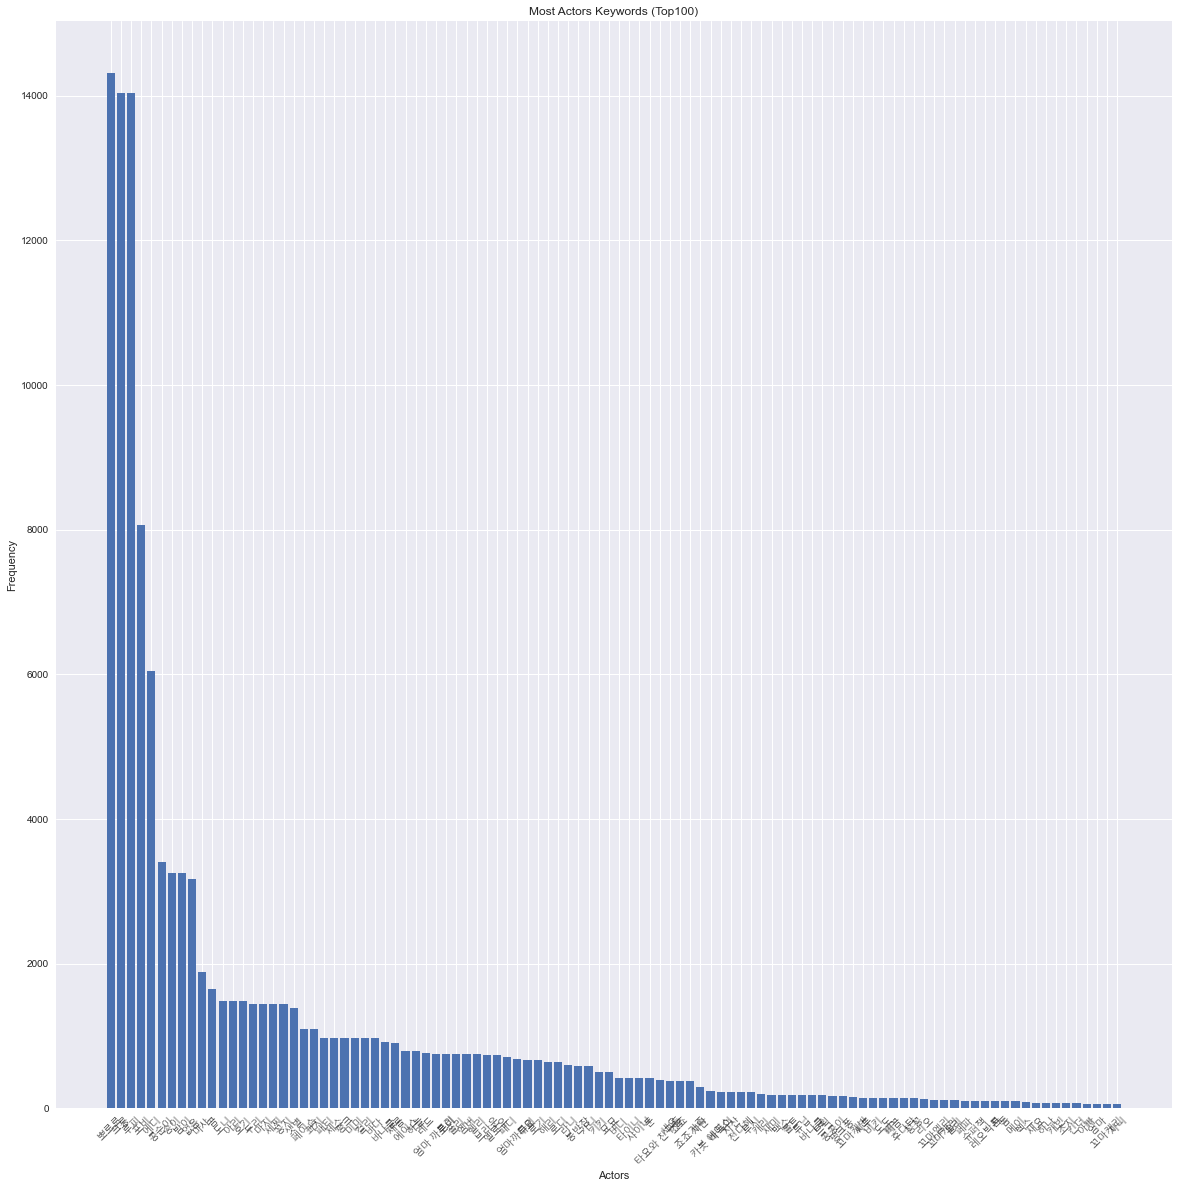

In [26]:
# 단어 취합
total = sum(df['actors'].values.tolist(),[])
# 단어의 출현빈도수 추출
total_frequency_dict = dict(Counter(total))
# 추출한 단어별 출현빈도수를 테이블화
frequency_df = pd.DataFrame(zip(total_frequency_dict.keys(), total_frequency_dict.values()),columns=['name','frequency'])
# 빈도 수를 기준으로 내림차순
frequency_df = frequency_df.sort_values(by='frequency', ascending=False).head(100)

plt.figure(figsize=(20,20))
heights = frequency_df.frequency.values.tolist()
bars = frequency_df.name.values.tolist()
y_pos = range(len(bars))
plt.bar(y_pos, heights)
# Rotation of the bars names
plt.xticks(y_pos, bars, rotation=45,fontproperties=prop,fontsize=10)
plt.xlabel('Actors') 
#y-axis labels 
plt.ylabel('Frequency') 
#plot title 
plt.title('Most Actors Keywords (Top100)') 
#display 
plt.show();

# 영화 줄거리 시각화

In [28]:
# 형태소에서 명사/형용사들만 추출
def tokenize(x):
    kkma = Kkma()
    x = kkma.pos(x)
    nouns = [n for n, tag in x if tag in ["VA","VV","MAG","MM",'NNG'] ]
    return nouns

# 단어별 빈도수 추출
df['summary'] = df['summary'].apply(lambda x: tokenize(x))

# 단어 취합
total = sum(df['summary'].values.tolist(),[])
# 단어의 출현빈도수 추출
total_frequency_dict = dict(Counter(total))
# 추출한 단어별 출현빈도수를 테이블화
frequency_df = pd.DataFrame(zip(total_frequency_dict.keys(), total_frequency_dict.values()),columns=['name','frequency'])
# 빈도 수를 기준으로 내림차순
frequency_df = frequency_df.sort_values(by='frequency', ascending=False)
# 2회 이하의 빈도수를 가진 단어들은 제거
frequency_df = frequency_df.loc[frequency_df['name'].str.len()>=2]


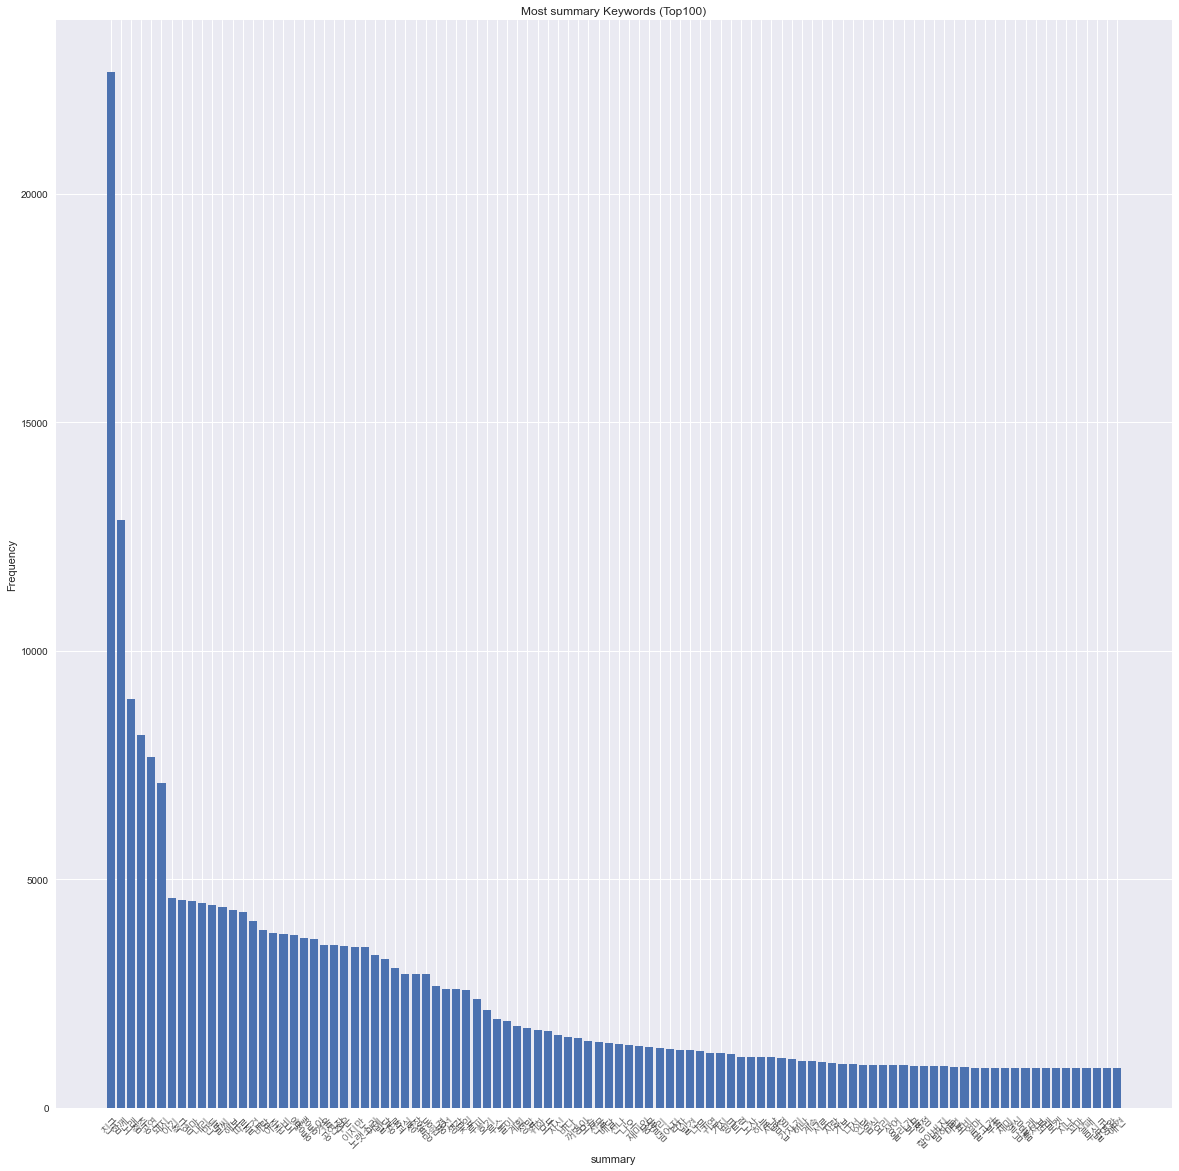

In [29]:
plt.figure(figsize=(20,20))
heights = frequency_df.head(100).frequency.values.tolist()
bars = frequency_df.head(100).name.values.tolist()
y_pos = range(len(bars))
plt.bar(y_pos, heights)
# Rotation of the bars names
plt.xticks(y_pos, bars, rotation=45,fontproperties=prop,fontsize=10)
plt.xlabel('summary') 
#y-axis labels 
plt.ylabel('Frequency') 
#plot title 
plt.title('Most summary Keywords (Top100)') 
#display 
plt.show();